In [1]:
# Restricted Boltzmann Machines

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline   
plt.rcParams['image.cmap'] = 'gray'
from sklearn.neural_network import BernoulliRBM
from sklearn.pipeline import Pipeline
import pandas as pd

In [3]:
def gen_mnist_image(X):
    return np.rollaxis(np.rollaxis(X[0:200].reshape(20, -1, 28, 28), 0, 2), 1, 3).reshape(-1, 20 * 28)

In [4]:
X_train = pd.read_csv('train.csv').values[:,1:]
X_train = (X_train - np.min(X_train, 0)) / (np.max(X_train, 0) + 0.0001)  # 0-1 scaling

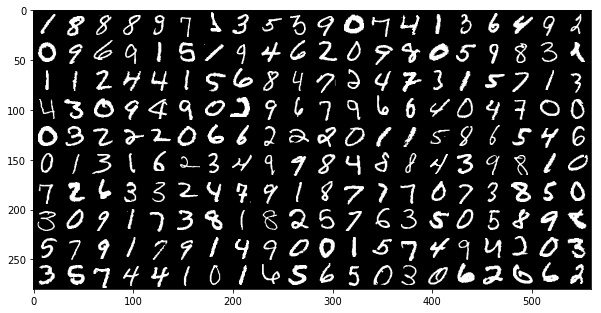

In [5]:
plt.figure(figsize=(10,20))
plt.imshow(gen_mnist_image(X_train))

In [13]:
rbm = BernoulliRBM(n_components=100, learning_rate=0.01, random_state=0, verbose=True)
rbm.fit(X_train)

[BernoulliRBM] Iteration 1, pseudo-likelihood = -119.88, time = 3.52s
[BernoulliRBM] Iteration 2, pseudo-likelihood = -104.69, time = 4.19s
[BernoulliRBM] Iteration 3, pseudo-likelihood = -97.89, time = 4.24s
[BernoulliRBM] Iteration 4, pseudo-likelihood = -93.32, time = 6.25s
[BernoulliRBM] Iteration 5, pseudo-likelihood = -90.42, time = 6.18s
[BernoulliRBM] Iteration 6, pseudo-likelihood = -88.14, time = 4.56s
[BernoulliRBM] Iteration 7, pseudo-likelihood = -87.06, time = 5.98s
[BernoulliRBM] Iteration 8, pseudo-likelihood = -85.23, time = 6.27s
[BernoulliRBM] Iteration 9, pseudo-likelihood = -83.69, time = 5.00s
[BernoulliRBM] Iteration 10, pseudo-likelihood = -83.27, time = 5.36s


BernoulliRBM(batch_size=10, learning_rate=0.01, n_components=100, n_iter=10,
             random_state=0, verbose=True)

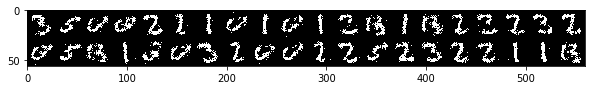

In [42]:
n_i = 40
xx = np.random.rand(n_i,np.shape(X_train[:n_i])[1])
for ii in range(1000):
    for n in range(n_i):
        xx[n,:] = rbm.gibbs(xx[n,:])
        
        


plt.figure(figsize=(10,20))
plt.imshow(gen_mnist_image(xx))

In [41]:
w = rbm.components_
b_h = rbm.intercept_hidden_
b_v = rbm.intercept_visible_
print(np.shape(w))

(100, 784)


In [90]:
# Gibbs sampling

def np_sigmoid(x):
    return 1/(1+np.exp(-x));

def gibbs(h,v,w,b_h,b_v):
    
    # First, we update the hidden units
    p_h = np_sigmoid(np.matmul(w,v) + b_h)      # vector of update probabilities for the hidden units
    s = np.random.rand(len(h))                  # auxiliary random vector
    h = np.less(s,p_h).astype(int)
    
    
    # Second, we update the visible units
    p_v = np_sigmoid(np.matmul(w.T,h) + b_v)    #vector of update probabilities for the visible units
    s = np.random.rand(len(v))                  # auxiliary random vector
    v = np.less(s,p_v).astype(int) 
    
    
    return (h,v);

In [81]:
xx = np.random.rand(n_i,np.shape(X_train[:n_i])[1])
hl = np.random.rand(n_i,100)
for ii in range(1000):
    for n in range(n_i):
        (hl[n],xx[n]) = gibbs(hl[n],xx[n],w,b_h,b_v) 

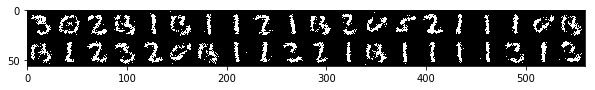

In [82]:
plt.figure(figsize=(10,20))
plt.imshow(gen_mnist_image(xx))

In [ ]:
# RBM for feature learning 

In [172]:
from scipy.ndimage import convolve
from sklearn import linear_model, datasets, metrics
from sklearn.model_selection import train_test_split
from sklearn.base import clone

In [202]:
def nudge_dataset(X, Y):
    """
    This produces a dataset 5 times bigger than the original one,
    by moving the 8x8 images in X around by 1px to left, right, down, up
    """
    direction_vectors = [
        [[0, 1, 0],
         [0, 0, 0],
         [0, 0, 0]],

        [[0, 0, 0],
         [1, 0, 0],
         [0, 0, 0]],

        [[0, 0, 0],
         [0, 0, 1],
         [0, 0, 0]],

        [[0, 0, 0],
         [0, 0, 0],
         [0, 1, 0]]]

    def shift(x, w):
        return convolve(x.reshape((8, 8)), mode='constant', weights=w).ravel()

    X = np.concatenate([X] +
                       [np.apply_along_axis(shift, 1, X, vector)
                        for vector in direction_vectors])
    Y = np.concatenate([Y for _ in range(5)], axis=0)
    return X, Y


# Load Data
digits = datasets.load_digits()
X = np.asarray(digits.data, 'float32')
X, Y = nudge_dataset(X, digits.target)




X = (X - np.min(X, 0)) / (np.max(X, 0) + 0.0001)  # 0-1 scaling

X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.2, random_state=0)



(7188, 64)


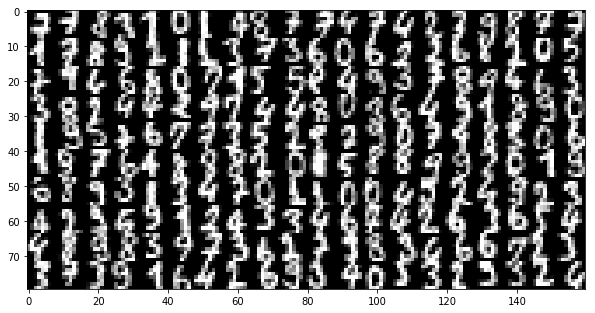

In [203]:
def gen_image(X):
    return np.rollaxis(np.rollaxis(X[0:200].reshape(20, -1, 8, 8), 0, 2), 1, 3).reshape(-1, 20 * 8)

plt.figure(figsize=(10,20))
plt.imshow(gen_image(X_train))

In [214]:
# Logistic regression
logistic = linear_model.LogisticRegression(solver='newton-cg', tol=1,
                                           multi_class='multinomial')


# RBM 

rbm = BernoulliRBM(random_state=0, verbose=True)

rbm_features_classifier = Pipeline(
    steps=[('rbm', rbm), ('logistic', logistic)])

In [220]:
# Hyper-parameters. 

rbm.learning_rate = 0.06
rbm.n_iter = 20
rbm.n_components = 100


logistic.C = 6000

In [221]:
# Training RBM-Logistic Pipeline
rbm_features_classifier.fit(X_train, Y_train)

[BernoulliRBM] Iteration 1, pseudo-likelihood = -25.39, time = 0.16s
[BernoulliRBM] Iteration 2, pseudo-likelihood = -23.77, time = 0.19s
[BernoulliRBM] Iteration 3, pseudo-likelihood = -22.94, time = 0.20s
[BernoulliRBM] Iteration 4, pseudo-likelihood = -21.91, time = 0.19s
[BernoulliRBM] Iteration 5, pseudo-likelihood = -21.69, time = 0.19s
[BernoulliRBM] Iteration 6, pseudo-likelihood = -21.06, time = 0.19s
[BernoulliRBM] Iteration 7, pseudo-likelihood = -20.89, time = 0.19s
[BernoulliRBM] Iteration 8, pseudo-likelihood = -20.64, time = 0.19s
[BernoulliRBM] Iteration 9, pseudo-likelihood = -20.36, time = 0.18s
[BernoulliRBM] Iteration 10, pseudo-likelihood = -20.09, time = 0.18s
[BernoulliRBM] Iteration 11, pseudo-likelihood = -20.08, time = 0.18s
[BernoulliRBM] Iteration 12, pseudo-likelihood = -19.82, time = 0.18s
[BernoulliRBM] Iteration 13, pseudo-likelihood = -19.64, time = 0.19s
[BernoulliRBM] Iteration 14, pseudo-likelihood = -19.61, time = 0.18s
[BernoulliRBM] Iteration 15, 

Pipeline(memory=None,
         steps=[('rbm',
                 BernoulliRBM(batch_size=10, learning_rate=0.06,
                              n_components=100, n_iter=20, random_state=0,
                              verbose=True)),
                ('logistic',
                 LogisticRegression(C=6000, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='multinomial', n_jobs=None,
                                    penalty='l2', random_state=None,
                                    solver='newton-cg', tol=1, verbose=0,
                                    warm_start=False))],
         verbose=False)

In [222]:
# Training the Logistic regression classifier directly on the pixel
raw_pixel_classifier = clone(logistic)
raw_pixel_classifier.C = 100.
raw_pixel_classifier.fit(X_train, Y_train)

LogisticRegression(C=100.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=None, solver='newton-cg', tol=1, verbose=0,
                   warm_start=False)

In [223]:
# Evaluation

Y_pred = rbm_features_classifier.predict(X_test)
print("Logistic regression using RBM features:\n%s\n" % (
    metrics.classification_report(Y_test, Y_pred)))


Y_pred = raw_pixel_classifier.predict(X_test)
print("Logistic regression using raw pixel features:\n%s\n" % (
    metrics.classification_report(Y_test, Y_pred)))


Logistic regression using RBM features:
              precision    recall  f1-score   support

           0       0.99      0.98      0.99       174
           1       0.91      0.92      0.91       184
           2       0.92      0.95      0.93       166
           3       0.96      0.88      0.91       194
           4       0.97      0.94      0.95       186
           5       0.93      0.93      0.93       181
           6       0.98      0.98      0.98       207
           7       0.93      0.99      0.96       154
           8       0.89      0.90      0.89       182
           9       0.91      0.93      0.92       169

    accuracy                           0.94      1797
   macro avg       0.94      0.94      0.94      1797
weighted avg       0.94      0.94      0.94      1797


Logistic regression using raw pixel features:
              precision    recall  f1-score   support

           0       0.90      0.93      0.91       174
           1       0.60      0.59      0.59  

In [ ]:
# Latent representations

In [326]:
X = pd.read_csv('../input/train.csv').values[:,1:]
Y = pd.read_csv('../input/train.csv').values[:,0]




X = (X - np.min(X, 0)) / (np.max(X, 0) + 0.0001)  # 0-1 scaling

X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.2, random_state=0)

In [327]:
rbm1 = BernoulliRBM(random_state=0, verbose=True)
rbm2 = BernoulliRBM(random_state=0, verbose=True)

dbm_features_classifier = Pipeline(
    steps=[('rbm1', rbm1), ('rbm2', rbm2), ('logistic', logistic)])

In [328]:
rbm1.learning_rate = 0.02
rbm1.n_iter = 20
rbm1.n_components = 200

rbm2.learning_rate = 0.02
rbm2.n_iter = 20
rbm2.n_components = 100

In [329]:
# Training RBM-Logistic Pipeline
dbm_features_classifier.fit(X_train, Y_train)

[BernoulliRBM] Iteration 1, pseudo-likelihood = -97.22, time = 4.14s
[BernoulliRBM] Iteration 2, pseudo-likelihood = -85.14, time = 4.73s
[BernoulliRBM] Iteration 3, pseudo-likelihood = -80.14, time = 6.68s
[BernoulliRBM] Iteration 4, pseudo-likelihood = -77.39, time = 6.70s
[BernoulliRBM] Iteration 5, pseudo-likelihood = -75.55, time = 6.71s
[BernoulliRBM] Iteration 6, pseudo-likelihood = -74.68, time = 5.62s
[BernoulliRBM] Iteration 7, pseudo-likelihood = -73.20, time = 6.00s
[BernoulliRBM] Iteration 8, pseudo-likelihood = -71.45, time = 6.72s
[BernoulliRBM] Iteration 9, pseudo-likelihood = -70.48, time = 6.94s
[BernoulliRBM] Iteration 10, pseudo-likelihood = -71.96, time = 6.90s
[BernoulliRBM] Iteration 11, pseudo-likelihood = -70.53, time = 6.21s
[BernoulliRBM] Iteration 12, pseudo-likelihood = -69.91, time = 6.48s
[BernoulliRBM] Iteration 13, pseudo-likelihood = -69.82, time = 6.37s
[BernoulliRBM] Iteration 14, pseudo-likelihood = -69.10, time = 6.95s
[BernoulliRBM] Iteration 15, 

Pipeline(memory=None,
         steps=[('rbm1',
                 BernoulliRBM(batch_size=10, learning_rate=0.02,
                              n_components=200, n_iter=20, random_state=0,
                              verbose=True)),
                ('rbm2',
                 BernoulliRBM(batch_size=10, learning_rate=0.02,
                              n_components=100, n_iter=20, random_state=0,
                              verbose=True)),
                ('logistic',
                 LogisticRegression(C=6000, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='multinomial', n_jobs=None,
                                    penalty='l2', random_state=None,
                                    solver='newton-cg', tol=1, verbose=0,
                                    warm_start=False))],
         verbose=False)

In [330]:
Y_pred = dbm_features_classifier.predict(X_test)
print("Logistic regression using RBM features:\n%s\n" % (
    metrics.classification_report(Y_test, Y_pred)))

Logistic regression using RBM features:
              precision    recall  f1-score   support

           0       0.97      0.98      0.98       813
           1       0.98      0.99      0.98       961
           2       0.95      0.95      0.95       860
           3       0.96      0.92      0.94       863
           4       0.94      0.92      0.93       827
           5       0.93      0.95      0.94       756
           6       0.97      0.98      0.97       841
           7       0.95      0.95      0.95       899
           8       0.93      0.93      0.93       768
           9       0.91      0.91      0.91       812

    accuracy                           0.95      8400
   macro avg       0.95      0.95      0.95      8400
weighted avg       0.95      0.95      0.95      8400




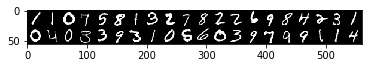

In [331]:
plt.imshow(gen_mnist_image(X[:40]))

In [342]:
model = Pipeline(
    steps=[('rbm1', rbm1), ('rbm2', rbm2)])

h2 = model.transform(X[:40])[7]

In [343]:
# Weights and biases after training

w_1 = rbm1.components_
b_h_1 = rbm1.intercept_hidden_
b_v_1 = rbm1.intercept_visible_

w_2 = rbm2.components_
b_h_2 = rbm2.intercept_hidden_
b_v_2 = rbm2.intercept_visible_

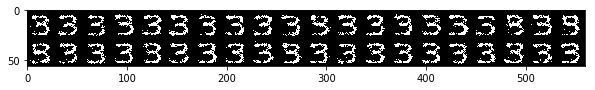

In [344]:
xx = np.random.rand(n_i,np.shape(X_train[:n_i])[1])
hl_1 = np.random.rand(n_i,200)

for ii in range(1000):
    for n in range(n_i):
        (hl_1[n],xx[n]) = gibbs(hl_1[n],xx[n],w_1,b_h_1 + np.matmul(w_2.T,h2),b_v_1) 
      
    
plt.figure(figsize=(10,20))
plt.imshow(gen_mnist_image(xx))    